In [2]:
# map atac to genes
import episcanpy
import scanpy as sc

# map atac peaks to genes
atac = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/trimodal_neurips/atac_hvf.h5ad')

atac.var.index = atac.var.index.map(lambda x: x.replace("-", ":", 1))
atac = episcanpy.tl.geneactivity(atac, gtf_file="../multiMAP_eval/gencode.v42.chr_patch_hapl_scaff.annotation.gtf")

atac = atac[:, ~atac.var.index.duplicated()]

atac.write_h5ad("atac_genes.h5ad")

ModuleNotFoundError: No module named 'episcanpy'

In [3]:
import sys, os

import numpy as np
from umap import UMAP
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd  
import scipy.sparse as sp

import scmomat 

plt.rcParams["font.size"] = 10

/home/icb/artur.szalata/miniconda3/envs/momat/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Load dataset
Make sure that the dataset get stored in a dictionary (`counts` in the script), with the item:
* `nbatches`: total number of batches
* `feats_name`: a dictionary storing the feature names for different modalities, e.g. `{"rna": np.array([aaaa, bbbb,...]), "atac": np.array([ccc, ddd, ...]), "protein": np.array([eee, fff, ...])}`
* `modality 1` (e.g. `rna` in the example below): a `list` store all data matrices correspond to modality 1, a element correspond to one batch, elements are ordered in the list following the ordering of batches. **The batches that does not have count matrix in corresponding modality is inserted `None` as placeholder**
* `modality 2` (e.g. `atac` in the example below): requirement the same as above.
* `modality 3` (e.g. `protein`): requirement the same as above.
* ...

#### Note:
* The number of item in the `feats_name` should match the number of modalities in `counts`. 
* The length of lists in `modality 1`, `modality 2`, `modality 3`, etc should have the same length, which is equal to `nbatches`. (missing matrices are denoted as `None` as explained above). **The matrices must be ordered according to the batch ID in each list,** so that scMoMaT can detact parallel sequenced batches.
* The data matrix in each modality (each list) should have the same set of features. You can do thie by 1. using the intersection of all genes/proteins in different batches; 2. Remap the chromatin regions according to the peaks of one batch. 
* The data matrix is of the shape `(ncells, nfeatures)`, and preprocessed with `utils.preprocess()` function.

One example template is shown as below, note that the features of data matrices are matched in advance. The connection matrix (`GxR.npz`) that is used to generate pseudo-count is also provided in advance (used the code in folder `calc_pseudo_count/calc_pseudo_count.R`). Feel free to modify on the template to use your dataset.


In [4]:
import scanpy as sc

In [5]:
data_dir = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/trimodal_neurips"

In [6]:
rna = sc.read(f'{data_dir}/rna_hvg_cite.h5ad')
rna = rna.concatenate(sc.read(f'{data_dir}/rna_hvg_multiome.h5ad'), batch_key='concat_key', index_unique=None)

In [7]:
genes = np.array(rna.var.index.tolist())

In [8]:
atac = sc.read('atac_genes.h5ad')

In [9]:
regions = np.array(atac.var.index.tolist())

In [10]:
adt = sc.read(f'{data_dir}/adt.h5ad')

In [11]:
proteins = np.array(adt.var.index.tolist())

In [12]:
feats_name = {"rna": genes, "atac": regions, "proteins": proteins}

In [13]:
batches_cite = list(set(adt.obs.batch.unique()).union(rna[rna.obs.Modality == "cite"].obs.batch.unique()))

In [14]:
batches_multiome = list(set(atac.obs.batch.unique()).union(rna[rna.obs.Modality == "multiome"].obs.batch.unique()))

In [15]:
n_batches = len(batches_cite) + len(batches_multiome)

In [21]:
counts_atacs = []
counts_rnas = []
counts_adts = []

for batch in batches_multiome:
    # process rna
    rna_index = rna[(rna.obs.batch == batch) & (rna.obs.Modality == "multiome")].obs.index
    rna_batch = np.array(rna[rna.obs.index.isin(rna_index)].X.todense())
    if len(rna_batch) > 0:
        rna_batch = scmomat.preprocess(rna_batch, modality = "RNA", log = False)
        counts_rnas.append(rna_batch)
    else:
        counts_rnas.append(None)
    # process atac
    atac_batch = atac[atac.obs.index.isin(rna_index)].X
    if len(atac_batch) > 0:
        atac_batch = scmomat.preprocess(atac_batch, modality = "ATAC")
        counts_atacs.append(atac_batch)
    else:
        counts_atacs.append(None)
    counts_adts.append(None)

for batch in batches_cite:
    # process rna
    rna_index = rna[(rna.obs.batch == batch) & (rna.obs.Modality == "cite")].obs.index
    rna_batch = np.array(rna[rna.obs.index.isin(rna_index)].X.todense())
    if len(rna_batch) > 0:
        rna_batch = scmomat.preprocess(rna_batch, modality = "RNA", log = False)
        counts_rnas.append(rna_batch)
    else:
        counts_rnas.append(None)
    # process adt
    adt_batch = np.array(adt[adt.obs.index.isin(rna_index)].X.todense())
    if len(adt_batch) > 0:
        adt_batch = scmomat.preprocess(adt_batch, modality = "protein")
        counts_adts.append(adt_batch)
    else:
        counts_adts.append(None)
    counts_atacs.append(None)

In [23]:
counts = {"feats_name": feats_name, "nbatches": n_batches, "rna":counts_rnas, "atac": counts_atacs, "proteins": counts_adts}

## Step 2: training scMoMaT
The hyper-parameter includes `lamb` for weight lambda in the objective function, `K` for the number of latent dimensions. The default parameter (`lamb = 0.001`, `K = 30`) works for most of the real datasets.

Input sanity check...
Finished.
Epoch 1, Validating Loss: 2339.1418
	 loss reconstruction: 2.33464
	 loss regularization: 4.50000
Epoch 1000, Validating Loss: 1876.5082
	 loss reconstruction: 1.87573
	 loss regularization: 0.77810
Epoch 2000, Validating Loss: 1850.6879
	 loss reconstruction: 1.85026
	 loss regularization: 0.42727
Epoch 3000, Validating Loss: 1841.6210
	 loss reconstruction: 1.84132
	 loss regularization: 0.30450
Epoch 4000, Validating Loss: 1835.9983
	 loss reconstruction: 1.83578
	 loss regularization: 0.22279
running time: 1280.7520020008087


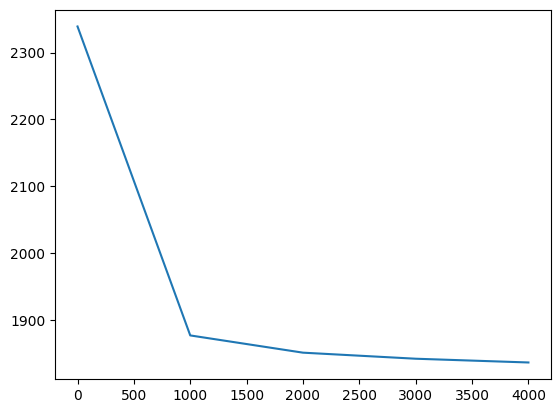

In [24]:
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Number of latent dimensions, key hyper-parameter, 20~30 works for most of the cases.
K = 30
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Here we list other parameters in the function for illustration purpose, most of these parameters are set as default value.
# weight on regularization term, default value
lamb = 0.001 
# number of total iterations, default value
T = 4000
# print the result after each ``interval'' iterations, default value
interval = 1000
# batch size for each iteraction, default value
batch_size = 0.1
# learning rate, default value
lr = 1e-2
# random seed, default value
seed = 0
# running device, can be CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#------------------------------------------------------------------------------------------------------------------------------------

start_time = time.time()
model = scmomat.scmomat_model(counts = counts, K = K, batch_size = batch_size, interval = interval, lr = lr, lamb = lamb, seed = seed, device = device)
losses = model.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

# Plot loss function
x = np.linspace(0, T, int(T/interval)+1)
plt.plot(x, losses)

In [25]:
# NOTE: Plot the result before post-processing
umap_op = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.2, random_state = 0) 
zs = model.extract_cell_factors()
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

In [26]:
labels_batches = []
for batch in range(n_batches):
    labels_batches.append(np.array(["batch " + str(batch)] * len(counts_rnas[batch]), dtype = object))

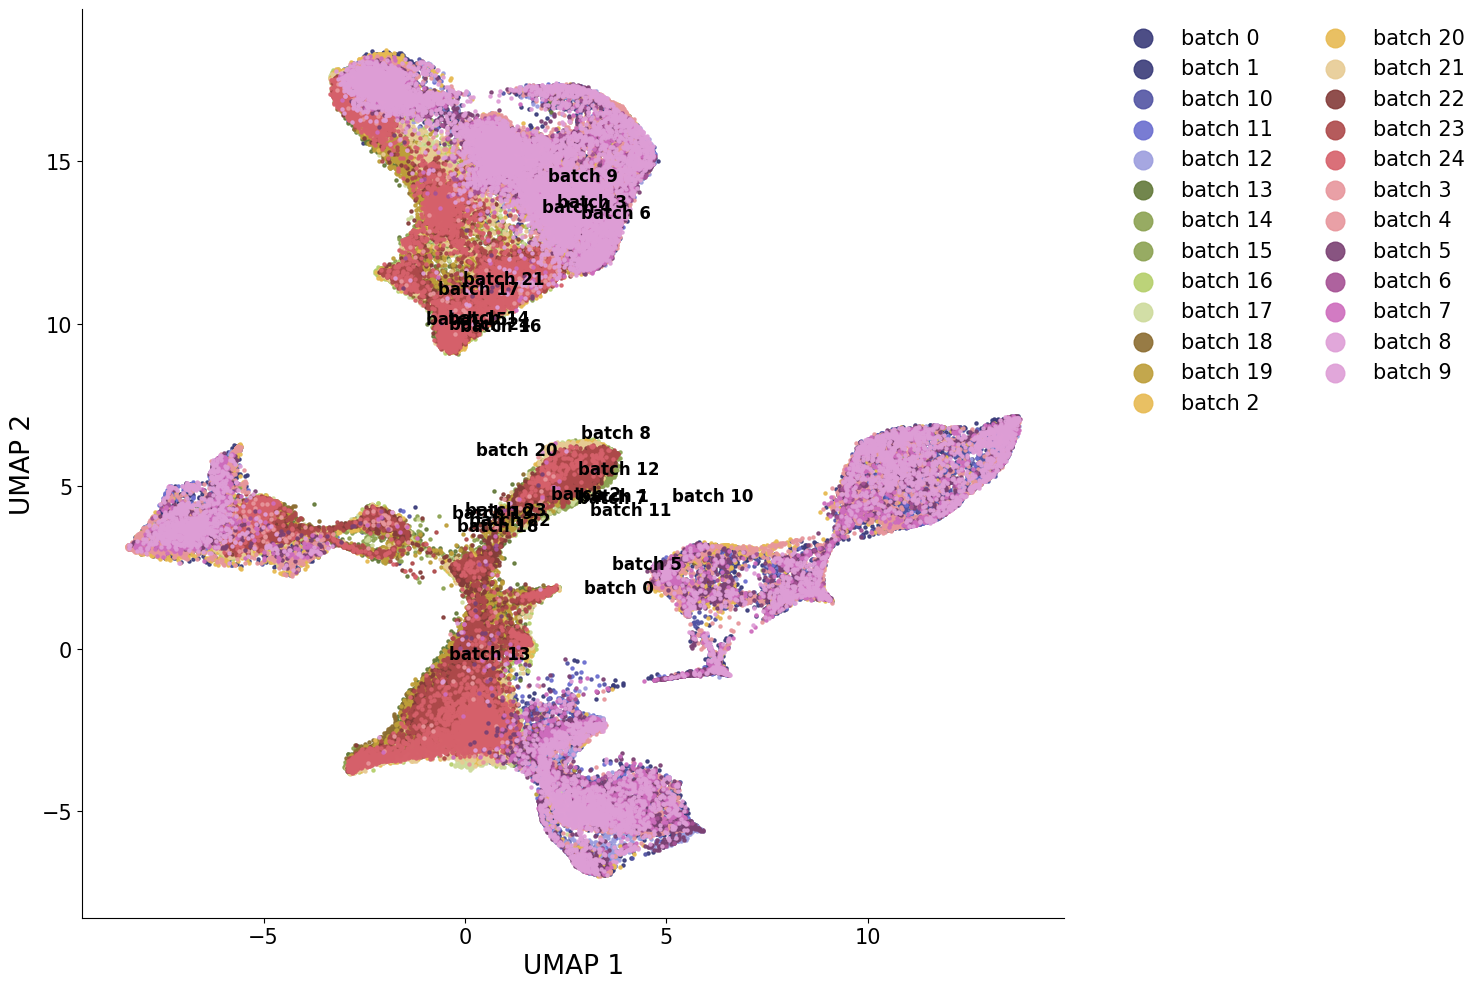

In [27]:
scmomat.plot_latent(x_umap, annos = np.concatenate(labels_batches), mode = "joint", save = None, figsize = (15,10), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)

In [28]:
rnas_names = []

for batch in batches_multiome:
    rnas_names.extend(rna[(rna.obs.batch == batch) & (rna.obs.Modality == "multiome")].obs.index.tolist())

for batch in batches_cite:
    rnas_names.extend(rna[(rna.obs.batch == batch) & (rna.obs.Modality == "cite")].obs.index.tolist())

In [29]:
# save intermediary results
zs = model.extract_cell_factors()

In [30]:
pd.DataFrame(np.concatenate(zs, axis=0), index=rnas_names).to_csv("momat_integrated.csv")

# The code below is for generating feature factors and it kills the kernel, hence cannot be executed

In [1]:
# load saves zs
# momat_integrated = pd.read_csv("momat_integrated.csv", index_col=0)
# momat_integrated = momat_integrated.join(rna.obs[["batch", "Modality"]])
# momat_integrated["batch"] = momat_integrated["batch"] + "_" + momat_integrated["Modality"]
# momat_integrated = momat_integrated.drop(columns=["Modality"])
# counts_per_batch = momat_integrated.groupby("batch")["0"].count().values
# zs = []
# total = 0
# for count in counts_per_batch:
#     zs.append(momat_integrated.iloc[total:total + count, :30].values)
#     total += count

In [ ]:
# post-processing
# neighborhood size (30~50)
n_neighbors = 30
# [Optional] neighborhood radius (between 0 and 1)
r = 0
# number of parallel CPU for calculation, default 1
njobs = 8
# obtain post-processed graph
# THIS STEP KILLS THE KERNEL
s_pair_dist, knn_indices, knn_dists = scmomat.post_process(zs, n_neighbors, njobs = 8, r = r)

In [ ]:
# cluster with post-processed graph
# cluster resolution
resolution = 0.9
labels_leiden = scmomat.leiden_cluster(X = None, knn_indices = knn_indices, knn_dists = knn_dists, resolution = resolution)
# visualize graph with umap
umap_op = scmomat.UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0.20, random_state = 0, metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices)
x_umap = umap_op.fit_transform(s_pair_dist)
scmomat.plot_latent(x_umap, annos = labels_leiden, mode = "joint", save = None, figsize = (10,7), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True, alpha = 0.7)

# 2nd stage training with cluster result, obtained feature factors
# [Optional] parameter lambda is set to be the default value 0.001
# [Optional] Update counts to include more training modalities (motif)
model2 = scmomat.scmomat_retrain(model = model, counts =  counts, labels = labels_leiden, device = device)
# number of iteractions is 2000
losses = model2.train(T = 2000)

# extract marker scores
score_feats = model2.extract_feature_factors()